### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsHead
from typing import *
from torch import nn
import torch
from lumin.optimisation.hyper_param import fold_lr_find
from lumin.nn.training.fold_train import fold_train_ensemble
from lumin.data_processing.hep_proc import *
from lumin.data_processing.pre_proc import fit_input_pipe
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.data.fold_yielder import *
from sklearn.metrics import roc_auc_score
from lumin.nn.metrics.eval_metric import EvalMetric
from lumin.nn.callbacks.cyclic_callbacks import *
from functools import partial

In [2]:
from pathlib import Path
PATH = Path('data/top/')

In [3]:
trn_store = pd.HDFStore(PATH/'train.h5')

In [4]:
torch.cuda.current_device()

0

In [5]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    return df

In [6]:
%%time
df = load_df(trn_store, None, 50)
train_feats = [f for f in df.columns if f != 'gen_target']
train_feats

['0_e',
 '0_px',
 '0_py',
 '0_pz',
 '1_e',
 '1_px',
 '1_py',
 '1_pz',
 '2_e',
 '2_px',
 '2_py',
 '2_pz',
 '3_e',
 '3_px',
 '3_py',
 '3_pz',
 '4_e',
 '4_px',
 '4_py',
 '4_pz',
 '5_e',
 '5_px',
 '5_py',
 '5_pz',
 '6_e',
 '6_px',
 '6_py',
 '6_pz',
 '7_e',
 '7_px',
 '7_py',
 '7_pz',
 '8_e',
 '8_px',
 '8_py',
 '8_pz',
 '9_e',
 '9_px',
 '9_py',
 '9_pz',
 '10_e',
 '10_px',
 '10_py',
 '10_pz',
 '11_e',
 '11_px',
 '11_py',
 '11_pz',
 '12_e',
 '12_px',
 '12_py',
 '12_pz',
 '13_e',
 '13_px',
 '13_py',
 '13_pz',
 '14_e',
 '14_px',
 '14_py',
 '14_pz',
 '15_e',
 '15_px',
 '15_py',
 '15_pz',
 '16_e',
 '16_px',
 '16_py',
 '16_pz',
 '17_e',
 '17_px',
 '17_py',
 '17_pz',
 '18_e',
 '18_px',
 '18_py',
 '18_pz',
 '19_e',
 '19_px',
 '19_py',
 '19_pz',
 '20_e',
 '20_px',
 '20_py',
 '20_pz',
 '21_e',
 '21_px',
 '21_py',
 '21_pz',
 '22_e',
 '22_px',
 '22_py',
 '22_pz',
 '23_e',
 '23_px',
 '23_py',
 '23_pz',
 '24_e',
 '24_px',
 '24_py',
 '24_pz',
 '25_e',
 '25_px',
 '25_py',
 '25_pz',
 '26_e',
 '26_px',
 '26_py

In [7]:
df.head()

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,47_pz,48_e,48_px,48_py,48_pz,49_e,49_px,49_py,49_pz,gen_target
375,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
377,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
378,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
379,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
380,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,-5.109442,3.084287,-1.266453,0.494149,-2.768527,1.996715,-1.341479,-0.095897,-1.475841,0


In [8]:
def proc_df(df:pd.DataFrame, train_feats:List[str]) -> None:
    print('Moving to float32')
    df[train_feats] = df[train_feats].values.astype('float32')
    print('Replacing zeros')
    df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
    print('Converting vectors')
    for v in get_vecs(train_feats): to_pt_eta_phi(df, v, True)    
    print('Processing event')
    proc_event(df, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='0', ref_vec_1='1', use_cartesian=True)
    print('Readding 0_py')
    df['0_py'] = 0.    
    print('Fitting preproc pipe')
    input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
    print('Transforming features')
    df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values

In [9]:
%%time
proc_df(df, train_feats)

Setting 0 to phi = 0
Setting 1 to positve phi
Setting 0 to positive eta
Converting to use_cartesian coordinates
CPU times: user 17min, sys: 17min 27s, total: 34min 27s
Wall time: 9min 43s


In [10]:
fpv = ['px', 'py', 'pz', 'e']
vecs = sorted(list(get_vecs([f for f in df.columns if f != 'gen_target'])))
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '2',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '3',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '4',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '5',
  '6',
  '7',
  '8',
  '9'])

In [11]:
df.head()

,0_e,1_e,2_e,3_e,4_e,5_e,6_e,7_e,8_e,9_e,...,26_px,26_py,26_pz,21_px,21_py,21_pz,18_px,18_py,18_pz,0_py
375,1.391909,-0.323398,0.361519,-0.620782,-0.916966,-0.806054,-0.680152,-0.834658,-0.855818,-0.798451,...,NaN,NaN,NaN,-1.729306,0.002001,-0.689985,-1.385531,-0.139015,-0.604924,0.0
377,-0.477880,-0.578750,-0.735295,-0.435916,-0.693441,-0.566297,-0.463218,-0.450489,-0.276326,-0.087723,...,-0.919438,-1.316233,-0.696607,-0.795517,-0.240421,-0.694252,-0.476926,-0.023703,-0.568453,0.0
378,0.106581,-0.312302,-0.165049,-0.061091,0.093901,0.401658,0.547718,0.881162,0.509855,0.706229,...,-0.117081,-0.933258,0.411070,0.167497,-0.639499,0.865707,0.284541,-0.565705,0.851748,0.0
379,1.261860,0.956757,2.004896,2.764982,3.597395,4.296310,4.334132,4.427033,0.829062,0.993456,...,NaN,NaN,NaN,-1.586142,-0.302448,-0.535040,-1.527504,0.101650,-0.546404,0.0
380,0.958639,1.751337,1.282238,0.597867,0.054458,-0.235763,-0.251830,0.401456,0.012017,0.851833,...,0.178821,-0.122861,1.424637,0.577934,0.666578,1.466733,0.232375,0.087221,1.189961,0.0


In [12]:
def df2fy(df:pd.DataFrame, train_feats:List[str], vecs:Optional[List[str]]=None, feats_per_vec:Optional[List[str]]=None,
            row_wise:Optional[bool]=None, n_folds:int=10) -> None:
    df2foldfile(df=df, n_folds=n_folds,
                cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
                matrix_feats_per_vec=feats_per_vec, matrix_vecs=vecs, matrix_row_wise=row_wise,
                savename=PATH/'train', targ_type='int', strat_key='gen_target')

In [13]:
train_fy = df2fy(df, train_feats, n_folds=10)

Saving fold 0 with 121101 events
Saving fold 1 with 121101 events
Saving fold 2 with 121101 events
Saving fold 3 with 121100 events
Saving fold 4 with 121100 events
Saving fold 5 with 121100 events
Saving fold 6 with 121100 events
Saving fold 7 with 121099 events
Saving fold 8 with 121099 events
Saving fold 9 with 121099 events


In [5]:
train_fy = FoldYielder(PATH/'train.hdf5')

In [6]:
fpv = ['px', 'py', 'pz', 'e']
vecs = sorted(list(get_vecs(train_fy.cont_feats)))

In [7]:
bs = 4096
objective = 'classifier'
n_out = 1

def get_model_builder(fy:FoldYielder, depth:int, width:int, head:AbsHead=CatEmbHead) -> ModelBuilder:
    opt_args = {'opt':'adam', 'eps':1e-08}
    cat_embedder = CatEmbedder.from_fy(fy)
    body = partial(FullyConnected, depth=depth, width=width, act='swish', dense=True)
    model_builder = ModelBuilder(objective, cont_feats=fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                                 opt_args=opt_args, body=body, head=head)
    print(Model(model_builder))
    return model_builder

In [8]:
class AUC(EvalMetric):
    def __init__(self, wgt_name:Optional[str]=None, targ_name:str='targets'):
        super().__init__(targ_name=targ_name, wgt_name=wgt_name)

    def evaluate(self, fy:FoldYielder, idx:int, y_pred:np.ndarray) -> float:
        df = self.get_df(fy, idx, y_pred)
        return roc_auc_score(df['gen_target'], df['pred'])

In [9]:
head = partial(InteractionNet, intfunc_depth=3,intfunc_width=20,intfunc_out_sz=10,
               outfunc_depth=3,outfunc_width=20,outfunc_out_sz=4,agg_method='flatten',
               feats_per_vec=fpv,vecs=vecs, act='swish')
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
200 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz', '15_e', '15_px', '15_py', '15_pz', '16_e', '16_px', '16_py', '16_pz', '17_e', '17_px', '17_py', '17_pz', '18_e', '18_px', '18_py', '18_pz', '19_e', '19_px', '19_py', '19_pz', '20_e', '20_px', '20_py', '20_pz', '21_e', '21_px', '21_py', '21_pz', '22_e', '22_px', '22_py', '22_pz', '23_e', '23_px', '23_py', '23_pz', '24_e', '24_px', '24_py', '24_pz', '25_e', '25_px', '25_py', '25_pz', '26_e', '26_px', '26_py', '26_pz', '27_e', '27_px', '27_py', '27_pz', '28_e', '28_px', '28_py', '28_pz', 

LR finder took 96.471s 


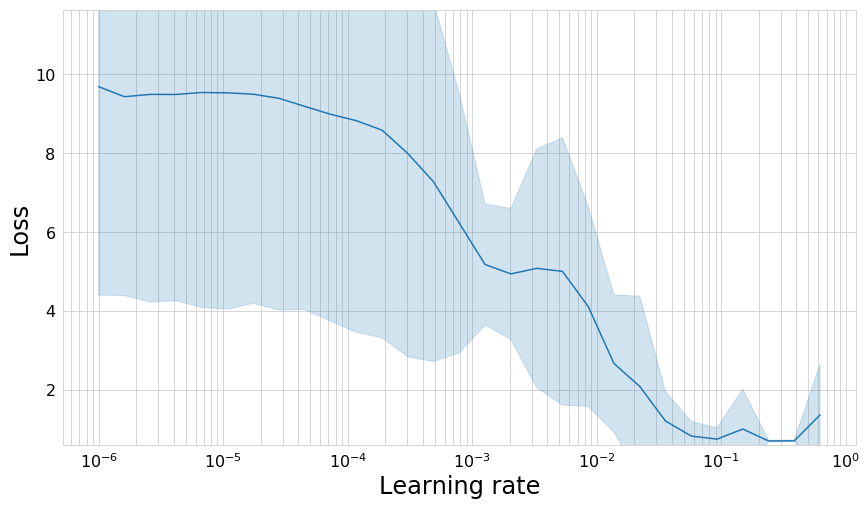

In [19]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0], n_folds=10)

In [20]:
callback_partials = [partial(OneCycle, lengths=[75, 150], lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
eval_metrics = {'AUC':AUC(wgt_name='weights')}

Training model 1 / 1, Val ID = 0


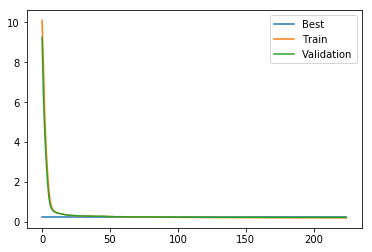

Early stopping after 225 epochs


RuntimeError: CUDA out of memory. Tried to allocate 8.84 GiB (GPU 0; 10.76 GiB total capacity; 9.04 GiB already allocated; 823.12 MiB free; 65.82 MiB cached)

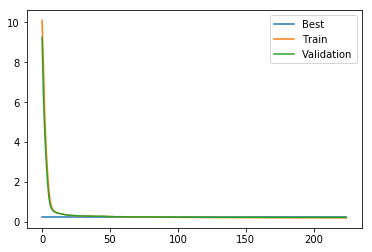

In [21]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=25, patience=25, bulk_move=False)

In [10]:
m = Model.from_save('train_weights/train_0.h5', model_builder)

In [23]:
df = train_fy.get_df(n_folds=1, fold_idx=0, inc_inputs=True, nan_to_num=True)

121101 datapoints loaded


/home/giles/lumin/lumin/nn/data/fold_yielder.py:351: UserWarning: weights not found in file
  warnings.warn(f"{wgt_name} not found in file")
/home/giles/lumin/lumin/nn/data/fold_yielder.py:362: UserWarning: pred not found in foldfile file
  warnings.warn(f'{pred_name} not found in foldfile file')


In [24]:
df.head()

,0_e,0_px,0_py,0_pz,1_e,1_px,1_py,1_pz,2_e,2_px,...,47_pz,48_e,48_px,48_py,48_pz,49_e,49_px,49_py,49_pz,gen_target
0,-0.477880,-0.130305,0.0,-0.604790,-0.578750,-0.205121,-0.637575,-0.626731,-0.735295,-0.481342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1.261860,0.132975,0.0,1.517104,0.956757,-0.257451,-0.701617,1.232876,2.004896,0.595778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.422270,-0.668927,0.0,0.768494,1.875306,0.335671,-0.250974,2.051975,3.397774,1.451958,...,-0.130806,0.588829,-0.912435,0.570579,1.094926,0.022015,-0.949981,0.437226,0.525619,0
3,-0.184445,-1.130559,0.0,0.207748,0.622027,-0.907048,1.520234,0.973144,1.037619,-0.996550,...,1.920102,1.354995,0.330436,-0.516818,1.680512,4.597117,0.325267,0.637243,4.984232,0
4,0.167796,-0.315360,0.0,0.423631,0.616609,0.128942,-0.715362,0.813413,1.614737,1.128574,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [26]:
p = m.predict(df, bs=bs)

In [31]:
roc_auc_score(df.gen_target, p)

0.9628783150040936